# coding AI

Assuming your environment is ready for python3 we would need pytorch installed
I suggest you use conda to generate your DL dedicated library area for this code, then it will not interfere with any pre-installed library you have locally :
<br>conda create -n torchenv python tensorflow-gpu jupyter matplotlib
<br>activate torchenv
<br>conda install -c pytorch pytorch
<br>pip install torchvision
<br>pip install torchsummary


<br><br>
in case of error importing pytorch just try this : https://gist.githubusercontent.com/peterjc123/21143c0c9426a025618260dde5b6219a/raw/872604dd79352f3dc94380699af4e7c1be2ba0d5/check_import.py


In [25]:
# import all the needed libraries

import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable

import random
import matplotlib.pyplot as plt
%matplotlib inline

from torch import optim
from torch.nn.parameter import Parameter
import torch.nn.init as init
import numpy as np
import math,os

from PIL import Image,ImageOps

print('##Import : OK')

##Import : OK



# detect device that will process this AI code

Let’s confirm gpu is detected properly and display pytorch version



In [2]:
# device variable will be used later to point to appropriate device directly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)#shows cuda if gpu is detected else shows cpu
print("Pytorch: {}".format(torch.__version__))

cuda
Pytorch: 0.4.1


# goal

Be clear on your goal.
Here we want to draw a number and let our AI model tell us which number it is,between 0 and 9, and possibly in an accurate way :)

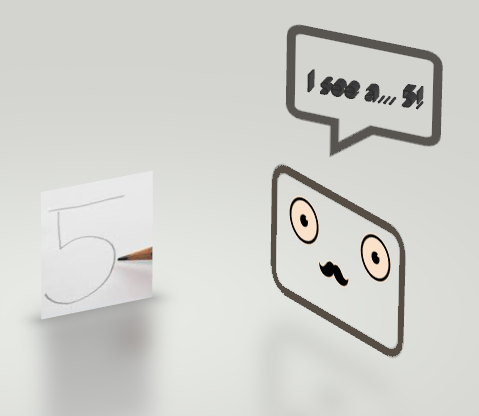

# choose model

Here it is a small model named <b>Net</b>. 
<br>2 conv 2d, 1 dropout 2 full connected.
<br>For now we want to focus on the model output.
<br>Since we have 10 digits to recognize here, we want the model to give 10 output, aka, 10 classes.

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # python 3 allows quick syntax here instead of using super(Net,self)  
        self.conv1 = nn.Conv2d(
            1, #input
            10, #output nb_filters
            stride=1, #filter step
            kernel_size=5) #filter size
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # randomly zero some input - default is 50%
        self.fc1 = nn.Linear(320, 50) # fully connected layer
        self.fc2 = nn.Linear(50, 10) # output is 10 classes

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # input 1,28,28 output 10,14,14
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # input 10,14,14 output 20,7,7
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x)) #activation
        x = F.dropout(x, training=self.training)#dropout prevents the model from placing too much trust in any of the input features
        x = self.fc2(x) # reduce the output
        return F.log_softmax(x, dim=1)

# get normalization actual values
 instead of using hardcoded values, and knowing normalization values are the mean and the std deviation of the dataset, 
this function below will help extracting from the dataset, proper values to use for the normalization


In [4]:
def getnormalization_values(): 
    train_dataset=torchvision.datasets.MNIST(root='data/', train=True, transform=transforms.Compose([transforms.ToTensor()]), download=True)
    mean=float(train_dataset.train_data.float().mean()/255)
    std=float(train_dataset.train_data.float().std()/255)
    train_sample=train_dataset[0][0]
    return mean,std,train_sample
# for dataset with color and natural image like cifar, formula would be different
# https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457/12

# load dataset - mnist - that matches the model output : 10 classes [ digit from 0 to 9 ]

We want our model to recognize a digit from 0 to 9. So here in our surpervized AI code, we will use a big set of labeled images from the popular dataset mnist : 60000 handwritten digits, then our model can learn what a handwritten digit looks like.


In [9]:
# hyper parameters
batch_size = 32

mean,std,x00=getnormalization_values()

#Define transformations
transformations = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize((mean,mean,mean),(std,std,std))
])

# get datasets, with the auto extracted normalization values
train_dataset = torchvision.datasets.MNIST(root='data/', train=True, transform=transformations, download=True)
test_dataset = torchvision.datasets.MNIST(root='data/', train=False, transform=transformations)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

id=random.randint(0,len(train_loader))
sample=train_dataset[id][0]
#pic_height = 28 # let's not hardcode it and let the code guess it 
#pic_weight = 28 # by extracting actual value from the training set
pic_height=tuple(sample.size())[1] #28 for mnist 32 for cifar 224 for imagenet
pic_weight=tuple(sample.size())[2] #28 for mnist 32 for cifar 224 for imagenet

print('dataset is ready')
print('dataset dimension:',tuple(sample.size()))

print('Number of elements:',list(train_dataset.train_data.size())[0])

dataset is ready
dataset dimension: (1, 28, 28)
Number of elements: 60000


# train model

Our model so far is fresh and not optimized to recognize any digit, if we launch a prediction now it would not be beter than a 10 sides dice throw, result would be very random.
<br>To improve accuracy we will recursively let it know when it is wrong for it to correct itself and get closer of the expected result - this is the training process - our model will weight itself to generate more accurate output at each iteration.


In [11]:
# The learning rate function below dynamically adjusta itself

def isNotImproving2(acc_list,nbitems):
    # https://stackoverflow.com/questions/30647330/calculate-if-trend-is-up-down-or-stable
    acc_list=acc_list[-nbitems:]
    A10=sum(range(nbitems+1))
    B10=sum(acc_list)
    C10=0
    for i in range(nbitems): C10=C10 + (i+1) * acc_list[i]
    D10=0
    for i in range(nbitems): D10=D10 + (i+1) * (i+1)
    b=(nbitems * C10 - A10 * B10) / (nbitems * D10 - A10 * A10)
    #print('b:',b)
    if b <= 0: return True
    return False

def adjust_learning_rate(count,optimizer,lr,acc_list,patience=3,nbitems=5):
    if len(acc_list) > nbitems:
        if isNotImproving2(acc_list,nbitems):
            count+=1  
            print('===non increasing trend detected-',count,'/',patience)
    if count >= patience:
        print('===patience is exceeded-steppingLR')
        lr=lr/10
        count=0
        for param_group in optimizer.param_groups:
            param_group["lr"]=lr
    return count,optimizer,lr

# train the model

def train(model,train_loader,optimizer,learning_rate,num_epochs,criterion,device,pic_weight,pic_height):
    train_loss_list,train_accuracy_list=[],[]
    train_accuracy,total,count=0,0,0
    for epoch in range(num_epochs):
        model.train()
        for i,(images,labels) in enumerate(train_loader):
            images=images.to(device)
            labels = labels.to(device)
            if torch.cuda.is_available(): model.cuda()
            outputs=model(images)
            #compute the loss based on the predictions and actual labels
            train_loss=criterion(outputs,labels)
            #Accuracy
            _,prediction=torch.max(outputs.data,1)
            total += labels.size(0)
            train_accuracy += (prediction == labels).sum().item()
            #Clear all accumulated gradients            
            optimizer.zero_grad()
            #Backpropagate the loss
            train_loss.backward()
            #adjust parameters according to the computed gradients
            optimizer.step()
            #display some stats
            if (i+1) % 100 == 0:
                train_accuracy_pct=100 * train_accuracy / total
                print ('Epoch [{}/{}], Step [{}/{}], Accuracy [{}/{}] {:.2f}%, Loss: {:.4f}, lr:{}'.format(
                  epoch+1, num_epochs,
                  i+1, len(train_loader),
                  train_accuracy,total,train_accuracy_pct,
                  train_loss.item(),
                  learning_rate))
                train_loss_list.append(train_loss.item()) #then we could plot the loss
                train_accuracy_list.append(train_accuracy_pct) #then we will plot the accuracy
                count,optimizer,learning_rate=adjust_learning_rate(count,optimizer,learning_rate,train_accuracy_list)
    return train_loss_list,train_accuracy_list

def display_summary(model,sample):
    try:
        summary(model,tuple(sample.size()))
    except:
        print(model) # display AI model in use
        print('Total params: ',sum([param.nelement() for param in model.parameters()]))

model=Net().to(device)
display_summary(model,sample)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [12]:
%%time
# Loss and optimizer
learning_rate = 0.001 # to start with when it will dynamically adjusts if needed
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train
num_epochs = 16
all_losses,all_accuracies = train(model, train_loader, optimizer,learning_rate, num_epochs, criterion, device,pic_weight,pic_height )


Epoch [1/16], Step [100/1875], Accuracy [1276/3200] 39.88%, Loss: 1.0747, lr:0.001
Epoch [1/16], Step [200/1875], Accuracy [3619/6400] 56.55%, Loss: 0.4979, lr:0.001
Epoch [1/16], Step [300/1875], Accuracy [6179/9600] 64.36%, Loss: 0.6142, lr:0.001
Epoch [1/16], Step [400/1875], Accuracy [8846/12800] 69.11%, Loss: 0.1852, lr:0.001
Epoch [1/16], Step [500/1875], Accuracy [11628/16000] 72.67%, Loss: 0.4103, lr:0.001
Epoch [1/16], Step [600/1875], Accuracy [14407/19200] 75.04%, Loss: 0.7168, lr:0.001
Epoch [1/16], Step [700/1875], Accuracy [17231/22400] 76.92%, Loss: 0.2655, lr:0.001
Epoch [1/16], Step [800/1875], Accuracy [20048/25600] 78.31%, Loss: 0.3055, lr:0.001
Epoch [1/16], Step [900/1875], Accuracy [22926/28800] 79.60%, Loss: 0.2785, lr:0.001
Epoch [1/16], Step [1000/1875], Accuracy [25848/32000] 80.78%, Loss: 0.2075, lr:0.001
Epoch [1/16], Step [1100/1875], Accuracy [28758/35200] 81.70%, Loss: 0.2444, lr:0.001
Epoch [1/16], Step [1200/1875], Accuracy [31671/38400] 82.48%, Loss: 0

Epoch [6/16], Step [600/1875], Accuracy [295880/319200] 92.69%, Loss: 0.0816, lr:0.001
Epoch [6/16], Step [700/1875], Accuracy [298906/322400] 92.71%, Loss: 0.9778, lr:0.001
Epoch [6/16], Step [800/1875], Accuracy [301956/325600] 92.74%, Loss: 0.1371, lr:0.001
Epoch [6/16], Step [900/1875], Accuracy [305014/328800] 92.77%, Loss: 0.1283, lr:0.001
Epoch [6/16], Step [1000/1875], Accuracy [308051/332000] 92.79%, Loss: 0.0819, lr:0.001
Epoch [6/16], Step [1100/1875], Accuracy [311114/335200] 92.81%, Loss: 0.0254, lr:0.001
Epoch [6/16], Step [1200/1875], Accuracy [314157/338400] 92.84%, Loss: 0.2285, lr:0.001
Epoch [6/16], Step [1300/1875], Accuracy [317191/341600] 92.85%, Loss: 0.0575, lr:0.001
Epoch [6/16], Step [1400/1875], Accuracy [320227/344800] 92.87%, Loss: 0.2538, lr:0.001
Epoch [6/16], Step [1500/1875], Accuracy [323308/348000] 92.90%, Loss: 0.1760, lr:0.001
Epoch [6/16], Step [1600/1875], Accuracy [326358/351200] 92.93%, Loss: 0.0887, lr:0.001
Epoch [6/16], Step [1700/1875], Accu

Epoch [11/16], Step [1000/1875], Accuracy [595222/632000] 94.18%, Loss: 0.0434, lr:0.001
Epoch [11/16], Step [1100/1875], Accuracy [598294/635200] 94.19%, Loss: 0.0783, lr:0.001
Epoch [11/16], Step [1200/1875], Accuracy [601360/638400] 94.20%, Loss: 0.3289, lr:0.001
Epoch [11/16], Step [1300/1875], Accuracy [604431/641600] 94.21%, Loss: 0.2168, lr:0.001
Epoch [11/16], Step [1400/1875], Accuracy [607520/644800] 94.22%, Loss: 0.3257, lr:0.001
Epoch [11/16], Step [1500/1875], Accuracy [610586/648000] 94.23%, Loss: 0.4262, lr:0.001
Epoch [11/16], Step [1600/1875], Accuracy [613647/651200] 94.23%, Loss: 0.0556, lr:0.001
Epoch [11/16], Step [1700/1875], Accuracy [616734/654400] 94.24%, Loss: 0.1729, lr:0.001
Epoch [11/16], Step [1800/1875], Accuracy [619827/657600] 94.26%, Loss: 0.0828, lr:0.001
Epoch [12/16], Step [100/1875], Accuracy [625233/663200] 94.28%, Loss: 0.1418, lr:0.001
Epoch [12/16], Step [200/1875], Accuracy [628315/666400] 94.28%, Loss: 0.2363, lr:0.001
Epoch [12/16], Step [30

Epoch [16/16], Step [1300/1875], Accuracy [893086/941600] 94.85%, Loss: 0.1174, lr:0.001
Epoch [16/16], Step [1400/1875], Accuracy [896160/944800] 94.85%, Loss: 0.0884, lr:0.001
Epoch [16/16], Step [1500/1875], Accuracy [899252/948000] 94.86%, Loss: 0.0508, lr:0.001
Epoch [16/16], Step [1600/1875], Accuracy [902342/951200] 94.86%, Loss: 0.3943, lr:0.001
Epoch [16/16], Step [1700/1875], Accuracy [905411/954400] 94.87%, Loss: 0.4048, lr:0.001
Epoch [16/16], Step [1800/1875], Accuracy [908496/957600] 94.87%, Loss: 0.1046, lr:0.001
Wall time: 3min 9s


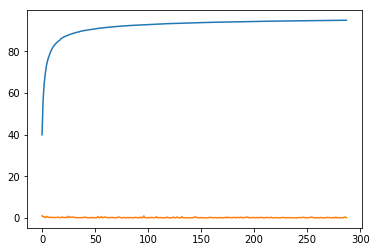

In [13]:
# draw accuracy and loss chart

plt.figure()
plt.plot(all_accuracies) #blue
plt.plot(all_losses) #orange
plt.show()

# test model

Once the model is trained we can use the 10000 images of our test dataset to see how good our trained model recognizes things right.


In [14]:
def test(model,test_loader,criterion,device,pic_height,pic_weight):
    model.eval()
    with torch.no_grad():
        test_loss,test_accuracy=0.0,0.0
        for images,labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
        
            if torch.cuda.is_available(): model.cuda()
            outputs=model(images)
            test_loss += criterion(outputs,labels).item()
            _,prediction=torch.max(outputs.data,1)
            test_accuracy += (prediction == labels).sum().item()
        test_loss = test_loss / len(test_loader.dataset)
        print('Test set: Average loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss,
        int(test_accuracy),len(test_loader.dataset),100 * float(test_accuracy) / len(test_loader.dataset)))
# test
test(model,test_loader,criterion,device,pic_height,pic_weight)

Test set: Average loss: 0.001118, Accuracy: 9884/10000 (98.84%)


# save trained model

If model is behaving in a satisfying way [high % of accuracy] we might want to use it later, when my computer is restarted, then we do not need to train it again. So let's save it, then next time we can load it straight.


In [15]:
#save it
model_dir = './data/pytorch_model'
model_nickname='/net'
if not os.path.exists(model_dir): os.makedirs(model_dir)
torch.save(model.state_dict(), model_dir + model_nickname)

print('model is saved in :',model_dir + model_nickname)

model is saved in : ./data/pytorch_model/net


# load trained model

For the sake of sharing working syntax, we will load the trained model, even if do not really need to do it here and now, since the model is already optimzed ( trained ) for my dataset in the memory.

In [16]:
#load it
model_dir = './data/pytorch_model'
model_nickname='/net'

#in a case we are loading from scratch,model need to be specify
class Net(nn.Module):
    def __init__(self):
        super().__init__() # python 3 allow quick synax her instead of super(Net,self)  
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model=Net().to(device) #set the vanilla model-it has to match the model we will import the weights from
model.load_state_dict(torch.load(model_dir + model_nickname))#import the result of previously saved training for that model
#if torch.cuda.is_available(): model.cuda()
#print(model)
try:
    summary(model,tuple(sample.size()))
except:
    print(model) # display AI model in use
    print('Total params: ',sum([param.nelement() for param in model.parameters()]))
print('Trained Model:',model_dir + model_nickname, 'loaded successfully')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------
Trained Model: ./data/pytorch_model/net loaded successfully


# test image prediction from test set

Let's take 1 random image in the test set and then display :
- prediction
- % of certainty
- expected value
- visual output

In [17]:
#prediction with test set

id=20 #9
x0=test_dataset[id][0]
x=Variable(x0.unsqueeze(0))
#x=x.cuda()
x=x.to(device)

outputs=model(x)

_,prediction=torch.max(outputs.data,1)
#prediction=prediction.cpu().numpy()
expectation=test_dataset[id][1]
result_softmax=F.softmax(outputs[0],dim=0)[prediction].data[0]
# display prediction, % of certainty, actual digit in the test set
print("prediction: {} - softmax: {} - correct value: {}".format(prediction[0],result_softmax,expectation))
#display normalized image
transforms.ToPILImage()(x0)

prediction: 9 - softmax: 0.9999346733093262 - correct value: 9


# test custom image

Let's do the same with an image I just created ( scan or picture from a digit written on a paper would do it too )


In [18]:
#prediction with custom set

image = Image.open('./ml/newnew3.png')
correct=3

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,mean,mean),(std,std,std))
])

image_tensor = transformations(image).float()

print(image_tensor.size())
#print(image_tensor.dim())
#print(image_tensor.type())

x=Variable(image_tensor.unsqueeze(0).float())
x=x.to(device)

outputs=model(x)

_,prediction=torch.max(outputs.data,1)
result_softmax=F.softmax(outputs[0],dim=0)[prediction].data[0]
print("{} (softmax: {},correct:{})".format(prediction[0],result_softmax,correct))

transforms.ToPILImage()(image_tensor.float())

torch.Size([3, 250, 250])


RuntimeError: Given groups=1, weight of size [10, 1, 5, 5], expected input[1, 3, 250, 250] to have 1 channels, but got 3 channels instead

## a fail! but why?

RuntimeError: Given groups=1, weight of size [10, 1, 5, 5], expected input[1, 3, 250, 250] to have 1 channels, but got 3 channels instead
<br>
<br>Custom image is not matching nb of channels in the model.
<br>Here is the nb of channels to the image in the dataset :
<i>print(tuple(sample.size())[0])</i>
<br>1
<br>Here is the nb of channel of the custom image :
<i>print(image_tensor.size()[0])</i>
<br>3
<br>
<br>1= grayscale, 3= color[rgb]
<br>
<br>-> We should ensure our custom image channel is a match to the dataset image channel.
<br>We can use torch vision to make the custom image from rgb to grayscale on the fly.
<br>    transforms.Grayscale(num_output_channels=1)

In [19]:
#prediction with custom set

image = Image.open('./ml/newnew3.png')
correct=3

transformations = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((mean,mean,mean),(std,std,std))
])

image_tensor = transformations(image).float()
print(image_tensor.size())
#print(image_tensor.dim())
#print(image_tensor.type())

x=Variable(image_tensor.unsqueeze(0).float())
x=x.to(device)

outputs=model(x)

_,prediction=torch.max(outputs.data,1)
result_softmax=F.softmax(outputs[0])[prediction].data[0]
print("{} (softmax: {},correct:{})".format(prediction,result_softmax,correct))

transforms.ToPILImage()(image_tensor.float())

torch.Size([1, 250, 250])


RuntimeError: invalid argument 2: size '[-1 x 320]' is invalid for input with 69620 elements at ..\aten\src\TH\THStorage.cpp:80

## Fail! but why ?

RuntimeError: invalid argument 2: size '[-1 x 320]' is invalid for input with 69620 elements at ..\aten\src\TH\THStorage.cpp:80

custom image is not matching size of dataset !
Here is the size to the image in the dataset :
print(image_tensor.size())
1,250,250 # 250 x 250
Here is the size of the custom image :
print(tuple(sample.size())
1,28,28 # 28 x 28

-> We should ensure our custome image size is a match to the dataset image size.
We can use torch vision to resize the custom image on the fly.
This is how :     transforms.Resize(28)

In [20]:
#prediction with custom set

image = Image.open('./ml/newnew3.png')
correct=3

transformations = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # rgb to grayscale
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((mean,mean,mean),(std,std,std))
])

image_tensor = transformations(image).float()
print(image_tensor.size())
#print(image_tensor.dim())
#print(image_tensor.type())

x=Variable(image_tensor.unsqueeze(0).float())
x=x.to(device)

outputs=model(x)

_,prediction=torch.max(outputs.data,1)
result_softmax=F.softmax(outputs[0],dim=0)[prediction].data[0]
print("{} (softmax: {},correct:{})".format(prediction[0],result_softmax,correct))

transforms.ToPILImage()(image_tensor.float())

torch.Size([1, 28, 28])
2 (softmax: 0.5976831316947937,correct:3)


# test custom image

No error now but the prediction is quite wrong... why ?!

Let's compare both images :
Here is one image in the dataset, with no normalization to preserve initial color for our human eyes comparaison.


In [21]:
transforms.ToPILImage()(x00)

In [23]:
#Here is the custom image.
image = Image.open('./ml/newnew3.png')

transformations = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # rgb to grayscale
    transforms.Resize(28),
    transforms.ToTensor(),
#    transforms.Normalize((mean,mean,mean),(std,std,std))
])

image_tensor = transformations(image).float()

transforms.ToPILImage()(image_tensor.float())

background is [white]!
-> In the mnist use case, we should ensure our image background color is a match to the dataset image background. Else accuracy of the prediction for custom image will be really low.
We can use torch vision to invert colors and make the images background a match, on the fly.
#torchvision.transforms.invert

In [26]:
#prediction with custom set
from PIL import Image
image = Image.open('./ml/newnew3.png')
correct=3

#https://github.com/sebastianberns/torchvision.transforms.invert
import torchvision.transforms.functional as F2

class Invert(object):
    """Inverts the color channels of an PIL Image
    while leaving intact the alpha channel.
    """
    
    def invert(self, img):
        """Invert the input PIL Image.
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        if not F2._is_pil_image(img):
            raise TypeError('img should be PIL Image. Got {}'.format(type(img)))

        if img.mode == 'RGBA':
            r, g, b, a = img.split()
            rgb = Image.merge('RGB', (r, g, b))
            inv = ImageOps.invert(rgb)
            r, g, b = inv.split()
            inv = Image.merge('RGBA', (r, g, b, a))
        elif img.mode == 'LA':
            l, a = img.split()
            l = ImageOps.invert(l)
            inv = Image.merge('LA', (l, a))
        else:
            inv = ImageOps.invert(img)
        return inv

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be inverted.
        Returns:
            PIL Image: Inverted image.
        """
        return self.invert(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'

transformations = transforms.Compose([
    Invert(),#invertbackground
    transforms.Grayscale(num_output_channels=1), # rgb to grayscale
    transforms.Resize(28),#resize
    transforms.ToTensor(),#to tensor
    transforms.Normalize((mean,mean,mean),(std,std,std))#normalize
])

image_tensor = transformations(image).float()

print(image_tensor.size())
#print(image_tensor.dim())
#print(image_tensor.type())

x=Variable(image_tensor.unsqueeze(0).float())
x=x.to(device)

outputs=model(x)

_,prediction=torch.max(outputs.data,1)
result_softmax=F.softmax(outputs[0],dim=0)[prediction].data[0]
print("{} (softmax: {},correct:{})".format(prediction[0],result_softmax,correct))
#display normalized picture
transforms.ToPILImage()(image_tensor.float())

torch.Size([1, 28, 28])
3 (softmax: 0.9999183416366577,correct:3)


# test custom image


prediction matches expectation -> success
Yay! Finally prediction is going through. We did it :)

And in the meantime you learned that channels background ( for non natural image ) and size, matter ;)